# Transfer learning
- Not train an entire Convolutional Network from scratch because of small data 
- Commonly, use pretrained ConvNet 

## Two major transfer learning scenarios 
1. Finetuning the convnet: random initialize 대신에 imagenet을 사용한 pretrained network사용 
2. Convnet as fixed feature extractor: 마지막 fc layer빼고 weights freezing후에 training

In [41]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   

### Load data 
- To classifty ants and bees
- 120 train set, 75 validation set

In [4]:
# data augmentation and normalization for training
# just normalization for validation 
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [9]:
data_dir = '../data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x])
                 for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, 
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Visualize a few images

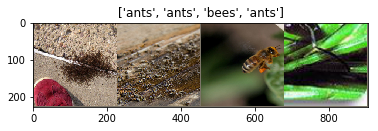

In [13]:
def imshow(inp, title=None):
    """Imshow for Tensor"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
# Get a batch of training data 
inputs, classes = next(iter(dataloaders['train']))

# make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Training the model 
- Scheduling the leraning rate 
- Saving the best model

In [44]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-'*10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                lables = labels.to(device)
                
                # Zero the parameter gradients 
                optimizer.zero_grad()
                
                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase 
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # statistics 
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase, epoch_loss, epoch_acc))
            
            # deep copy the model 
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:.4f}'.format(best_acc))
    
    #load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Visualizing the model predictions

In [54]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### Finetuning the convnet

In [46]:
resnet18 = models.resnet18(pretrained=True)
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, 2)

resnet18 = resnet18.to(device)

criterion = nn.CrossEntropyLoss()
# observe that all parameters are being optimized
optimizer_ft = optim.SGD(resnet18.parameters(), lr=.001, momentum=.9)
# decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=.1)


### Train and evaluate

In [47]:
model = train_model(resnet18, criterion, optimizer_ft, exp_lr_scheduler,
                   num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4708 Acc: 0.7705
val Loss: 0.2950 Acc: 0.8562

Epoch 1/24
----------
train Loss: 0.4453 Acc: 0.8033
val Loss: 0.7393 Acc: 0.7386

Epoch 2/24
----------
train Loss: 0.8117 Acc: 0.6885
val Loss: 0.9179 Acc: 0.6471

Epoch 3/24
----------
train Loss: 0.6318 Acc: 0.7746
val Loss: 0.4137 Acc: 0.8366

Epoch 4/24
----------
train Loss: 0.4864 Acc: 0.7910
val Loss: 0.2566 Acc: 0.9150

Epoch 5/24
----------
train Loss: 0.5096 Acc: 0.7787
val Loss: 0.5500 Acc: 0.7974

Epoch 6/24
----------
train Loss: 0.5909 Acc: 0.7746
val Loss: 0.2579 Acc: 0.8889

Epoch 7/24
----------
train Loss: 0.4204 Acc: 0.8074
val Loss: 0.2516 Acc: 0.9020

Epoch 8/24
----------
train Loss: 0.3260 Acc: 0.8525
val Loss: 0.2455 Acc: 0.8954

Epoch 9/24
----------
train Loss: 0.3063 Acc: 0.8648
val Loss: 0.2248 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.2903 Acc: 0.8730
val Loss: 0.2369 Acc: 0.9085

Epoch 11/24
----------
train Loss: 0.2632 Acc: 0.8811
val Loss: 0.2749 Acc: 0.8889

Ep

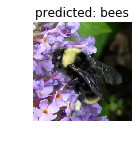

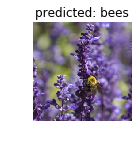

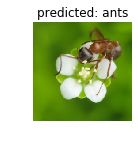

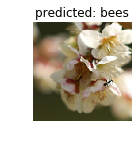

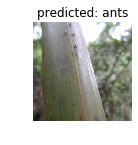

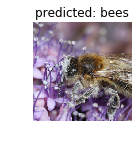

In [55]:
visualize_model(model)

### ConvNet as fixed feature extractor
- requires_grad == false, to freeze the params
- so not computed in backward()

In [56]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# parameters of newly constructed modules have requires_grad = True by defualt
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=.001, momentum=.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=.1)

### Train and evaluate 

In [57]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                        exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6832 Acc: 0.6557
val Loss: 0.2113 Acc: 0.9216

Epoch 1/24
----------
train Loss: 0.3890 Acc: 0.8238
val Loss: 0.1977 Acc: 0.9281

Epoch 2/24
----------
train Loss: 0.4138 Acc: 0.8115
val Loss: 0.1591 Acc: 0.9608

Epoch 3/24
----------
train Loss: 0.4104 Acc: 0.7951
val Loss: 0.2028 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.5624 Acc: 0.7336
val Loss: 0.2240 Acc: 0.9216

Epoch 5/24
----------
train Loss: 0.3674 Acc: 0.8361
val Loss: 0.2340 Acc: 0.9281

Epoch 6/24
----------
train Loss: 0.4837 Acc: 0.7910
val Loss: 0.1857 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.3291 Acc: 0.8648
val Loss: 0.1776 Acc: 0.9542

Epoch 8/24
----------
train Loss: 0.2882 Acc: 0.8730
val Loss: 0.1986 Acc: 0.9542

Epoch 9/24
----------
train Loss: 0.2797 Acc: 0.8811
val Loss: 0.2275 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.3715 Acc: 0.8361
val Loss: 0.1877 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3103 Acc: 0.8648
val Loss: 0.1864 Acc: 0.9542

Ep

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()